In [22]:
# 基础库
import os                  # 操作系统接口,提供文件/目录操作功能
import platform           # 获取系统平台信息,如操作系统类型、版本等
import sys               # Python解释器接口,提供Python运行环境信息
from io import BytesIO    # 二进制I/O操作,处理内存中的字节流数据
from PIL import Image     # Python图像处理库,提供图像打开、编辑等功能
import requests          # HTTP库,用于发送网络请求和处理响应
import time          # 用于计算时间差

# 科学计算和机器学习
import numpy as np        # 数值计算库,提供多维数组和数学函数
import tensorflow as tf   # 深度学习框架,用于构建和训练神经网络模型

# 数据可视化
import matplotlib.pyplot as plt         # 绘图库,创建各类统计图表
from matplotlib.font_manager import FontProperties, fontManager  # 字体管理,支持中文显示

# Jupyter工具
from IPython.display import clear_output  # 清理notebook输出内容

# Kaggle工具
import kagglehub         # Kaggle数据集管理工具,用于下载和使用数据集

# 系统环境信息
print("Python version:", sys.version)     # Python解释器版本
print("Platform:", platform.platform())   # 完整的平台标识符
print("System:", platform.system())       # 操作系统名称
print("Node:", platform.node())           # 网络节点名称
print("Release:", platform.release())     # 操作系统发行版本
print("Version:", platform.version())     # 操作系统版本号
print("Machine:", platform.machine())     # 硬件架构类型
print("Processor:", platform.processor()) # CPU类型

# 检查依赖包信息
!pip show tensorflow                      # 显示TensorFlow包信息

# 系统硬件信息
!cat /proc/cpuinfo | grep 'model name'    # CPU型号信息
!cat /proc/meminfo | grep 'MemTotal'      # 系统内存大小
!df -h                                    # 磁盘使用情况
!nvidia-smi                               # GPU信息(如有)


Python version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
Platform: Linux-6.1.123+-x86_64-with-glibc2.35
System: Linux
Node: b214d3115272
Release: 6.1.123+
Version: #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
Machine: x86_64
Processor: x86_64
Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tensorflow_decision_forests, tf_keras
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
MemTotal:       13289424 kB
Filesystem  

# 数据集



## 数据集获取

本项目使用的蘑菇图像数据集托管在 [Kaggle](https://www.kaggle.com/) 平台上，数据集名称为 [huizecai/mushroom](https://www.kaggle.com/datasets/huizecai/mushroom)。该数据集包含了多种常见蘑菇的高清图片，以及对应的分类标签。

为了方便数据获取，我们使用 `kagglehub` 库来自动下载和管理数据集。下面的代码单元格会直接从 Kaggle 下载数据集，并返回保存在本地的路径。数据集下载完成后会被缓存，后续运行时将直接使用缓存版本，无需重复下载。

In [23]:
# 设置数据集名称
dataset_name = "huizecai/mushroom"  # 指定要下载的Kaggle数据集名称

# 使用KaggleHub下载数据集
path = kagglehub.dataset_download(dataset_name)  # 下载数据集并获取保存路径

# 打印数据集文件的保存路径
print("Path to dataset files:", path)

# 设置数据和标签文件的具体路径
dataset_path = path + '/archive/data'  # 图片数据所在目录的路径
label_path = path + '/archive/label.txt'  # 标签文件的路径

Path to dataset files: /kaggle/input/mushroom


## 数据集类别统计分析

为了避免TensorFlow处理中文路径时可能出现的编码问题，本数据集采用了规范化的命名方式:
 - 各蘑菇种类的文件夹以"classXX"格式命名(XX为数字编号)
 - 使用label.txt文件建立文件夹编号与中文名称的映射关系
 - 这种设计既保证了系统兼容性，又方便了数据的管理和使用

In [24]:
# 获取所有子目录（即蘑菇类别）
# os.listdir() 列出指定目录下的所有文件和文件夹
# os.path.isdir() 判断是否为文件夹
# 使用列表推导式获取所有蘑菇类别的文件夹名
dir_names = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

# 读取 label.txt 并解析内容
# 创建一个空字典用于存储类别ID和名称的映射关系
categories = {}
# 以UTF-8编码打开label.txt文件
with open(label_path, 'r', encoding='utf-8') as file:
    for line in file:
        # 去除每行首尾空白字符并按空格分割
        parts = line.strip().split()
        # 确保每行包含两个部分:类别名称和ID
        if len(parts) == 2:
            category_name = parts[0]  # 第一部分为类别名称(中文)
            category_id = parts[1]    # 第二部分为类别ID
            categories[category_id] = category_name  # 建立ID到名称的映射

# 统计每种类别的图像数量
# 创建空字典存储每个类别的图片数量
category_counts = {}
for category_id in categories.keys():
    # 确保目录存在再进行统计
    if category_id in dir_names:
        # 构建完整的类别目录路径
        category_dir = os.path.join(dataset_path, category_id)
        # 统计jpg和jpeg格式的图片数量
        # 使用列表推导式过滤出图片文件并计数
        num_images = len([f for f in os.listdir(category_dir) if f.endswith('.jpg') or f.endswith('.jpeg')])
        # 使用中文类别名称作为键存储图片数量
        category_counts[categories[category_id]] = num_images

# 打印每个类别的图片数量统计结果
print("Category counts:", category_counts)

Category counts: {'羊肚菌': 170, '牛肝菌': 155, '鸡油菌': 153, '鸡枞菌': 165, '青头菌': 174, '奶浆菌': 182, '干巴菌': 156, '虎掌菌': 177, '白葱牛肝菌': 181, '老人头菌': 137, '猪肚菌': 109, '谷熟菌': 160, '白参菌': 171, '黑木耳': 174, '银耳': 127, '金耳': 157, '猴头菇': 176, '香菇': 168, '平菇': 161, '金针菇': 115, '口蘑': 139, '鹿茸菇': 154, '榆黄蘑': 177, '榛蘑': 172, '草菇': 149, '鸡腿菇': 137, '茶树菇': 159, '蟹味菇': 105, '白玉菇': 136, '红菇': 177, '杏鲍菇': 160, '松茸': 181, '姬松茸': 178, '松露': 151, '竹荪': 178, '虫草花': 177}


## 解决matplotlib中文显示问题

matplotlib默认不支持中文字体显示,可能会出现乱码。为了确保数据可视化结果能正确展示中文:
1. 我们将下载并使用"SimHei"(黑体)字体
2. 注册字体到matplotlib的字体管理器
3. 配置全局字体设置

这样可以保证后续所有图表中的中文标题、标签等都能正常显示。

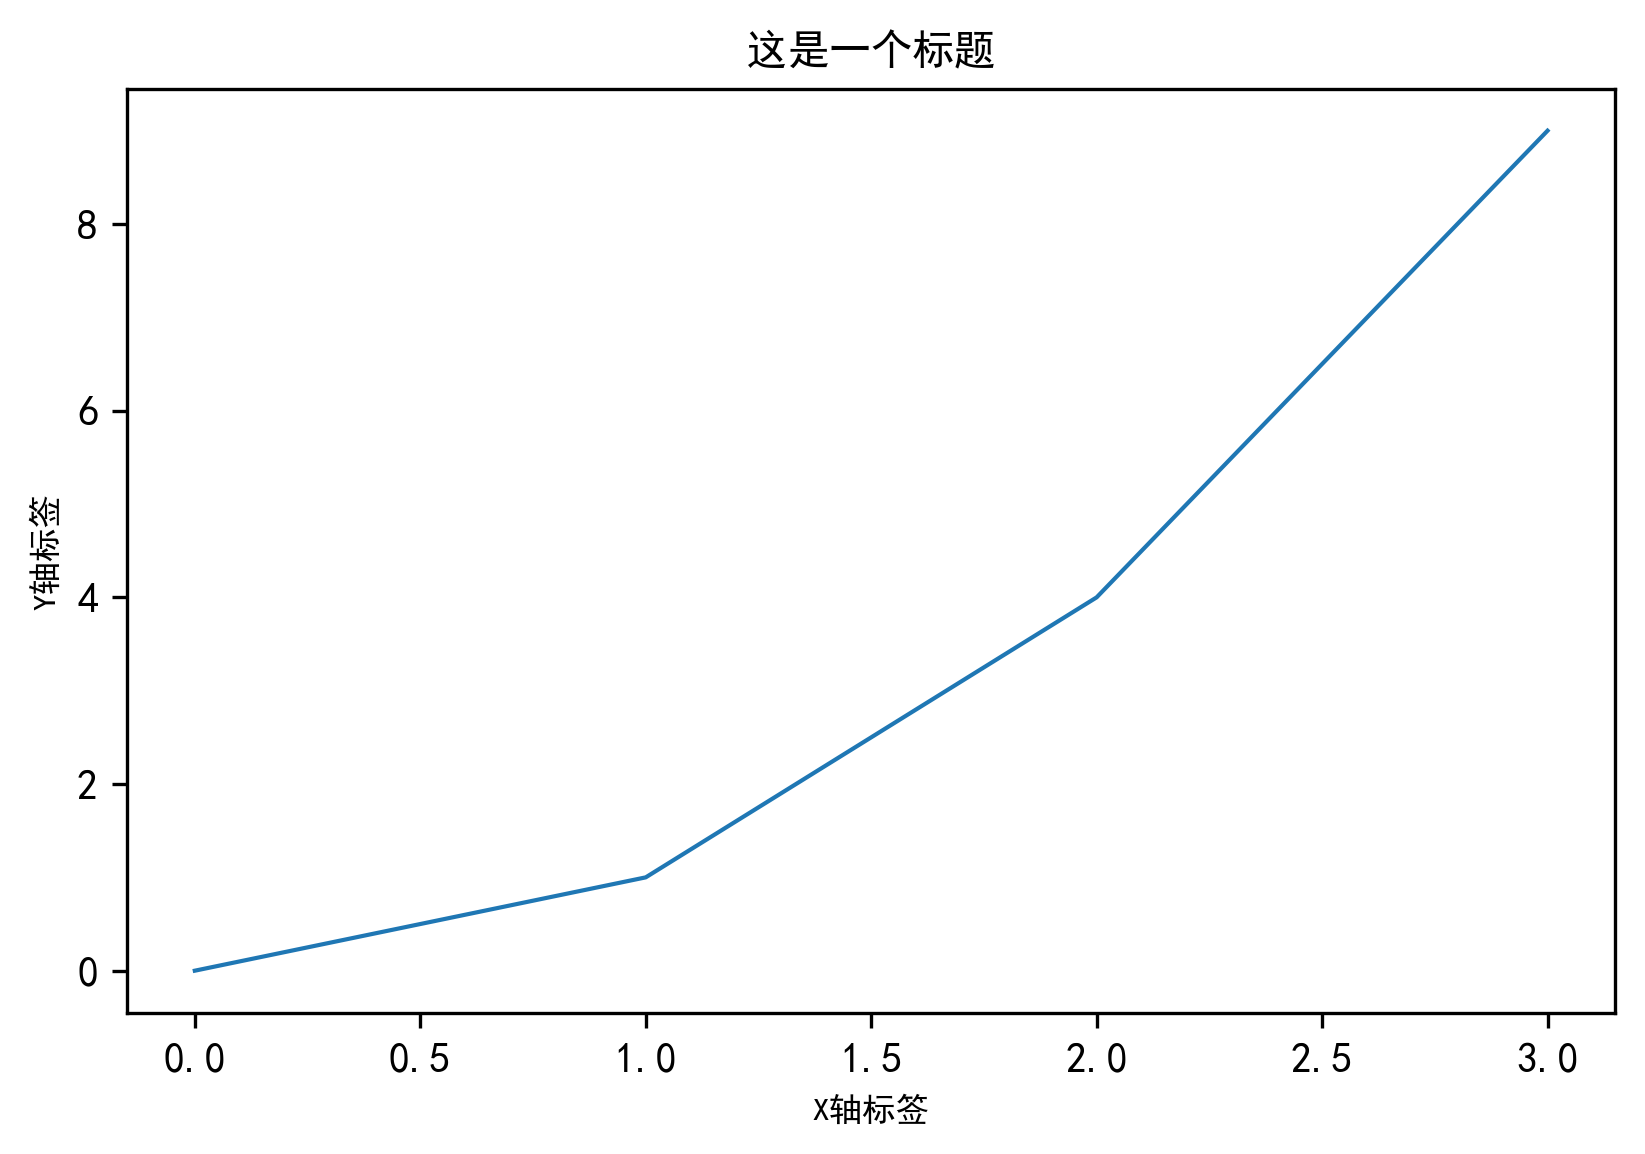

In [25]:
# 创建img目录(如果不存在)
if not os.path.exists('img'):
    os.makedirs('img')

# 设置字体文件的URL和本地保存路径
font_url = "https://github.com/caijihuize/Mushroom_Classification/raw/main/SimHei.ttf"  # 黑体字体文件的URL
font_name = "SimHei.ttf"  # 本地保存的字体文件名

# 如果字体文件不存在则下载
if not os.path.exists(font_name):
    # 使用requests下载字体文件
    response = requests.get(font_url)
    # 检查请求是否成功
    if response.status_code == 200:
        # 将内容写入文件
        with open(font_name, 'wb') as f:
            f.write(response.content)
    else:
        print(f"下载字体文件失败,状态码: {response.status_code}")

# 配置matplotlib的字体设置
fontManager.addfont(font_name)  # 将字体文件添加到matplotlib的字体管理器
font_prop = FontProperties(fname=font_name)  # 创建字体属性对象

# 设置全局字体配置
plt.rcParams['font.family'] = 'SimHei'  # 设置默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
plt.rcParams['font.size'] = 10  # 设置全局字体大小
plt.rcParams['axes.titlesize'] = 10  # 设置标题字体大小
plt.rcParams['axes.labelsize'] = 8  # 设置轴标签字体大小
plt.rcParams['figure.dpi'] = 300  # 设置图形DPI为300,提高显示清晰度
plt.rcParams['savefig.dpi'] = 600  # 设置保存图片的DPI为600,提高保存图片的清晰度

# 绘制测试图表验证中文显示
plt.figure(figsize=(6.4, 4))  # 设置图形大小
plt.title('这是一个标题', fontsize=10)  # 设置标题
plt.xlabel('X轴标签', fontsize=8)  # 设置X轴标签
plt.ylabel('Y轴标签', fontsize=8)  # 设置Y轴标签
plt.plot([0, 1, 2, 3], [0, 1, 4, 9], linewidth=1)  # 绘制简单的折线图,增加线宽提高清晰度

# 保存图表到img目录,使用更高质量的设置
plt.savefig('img/test_plot.png',
            bbox_inches='tight',  # 自动调整边界
            format='png',  # 使用PNG格式保存
            facecolor='white',  # 设置白色背景
            edgecolor='none',  # 无边框
            transparent=False)  # 不透明
plt.show()  # 显示图表

## 绘制各种类图片数量的柱状图

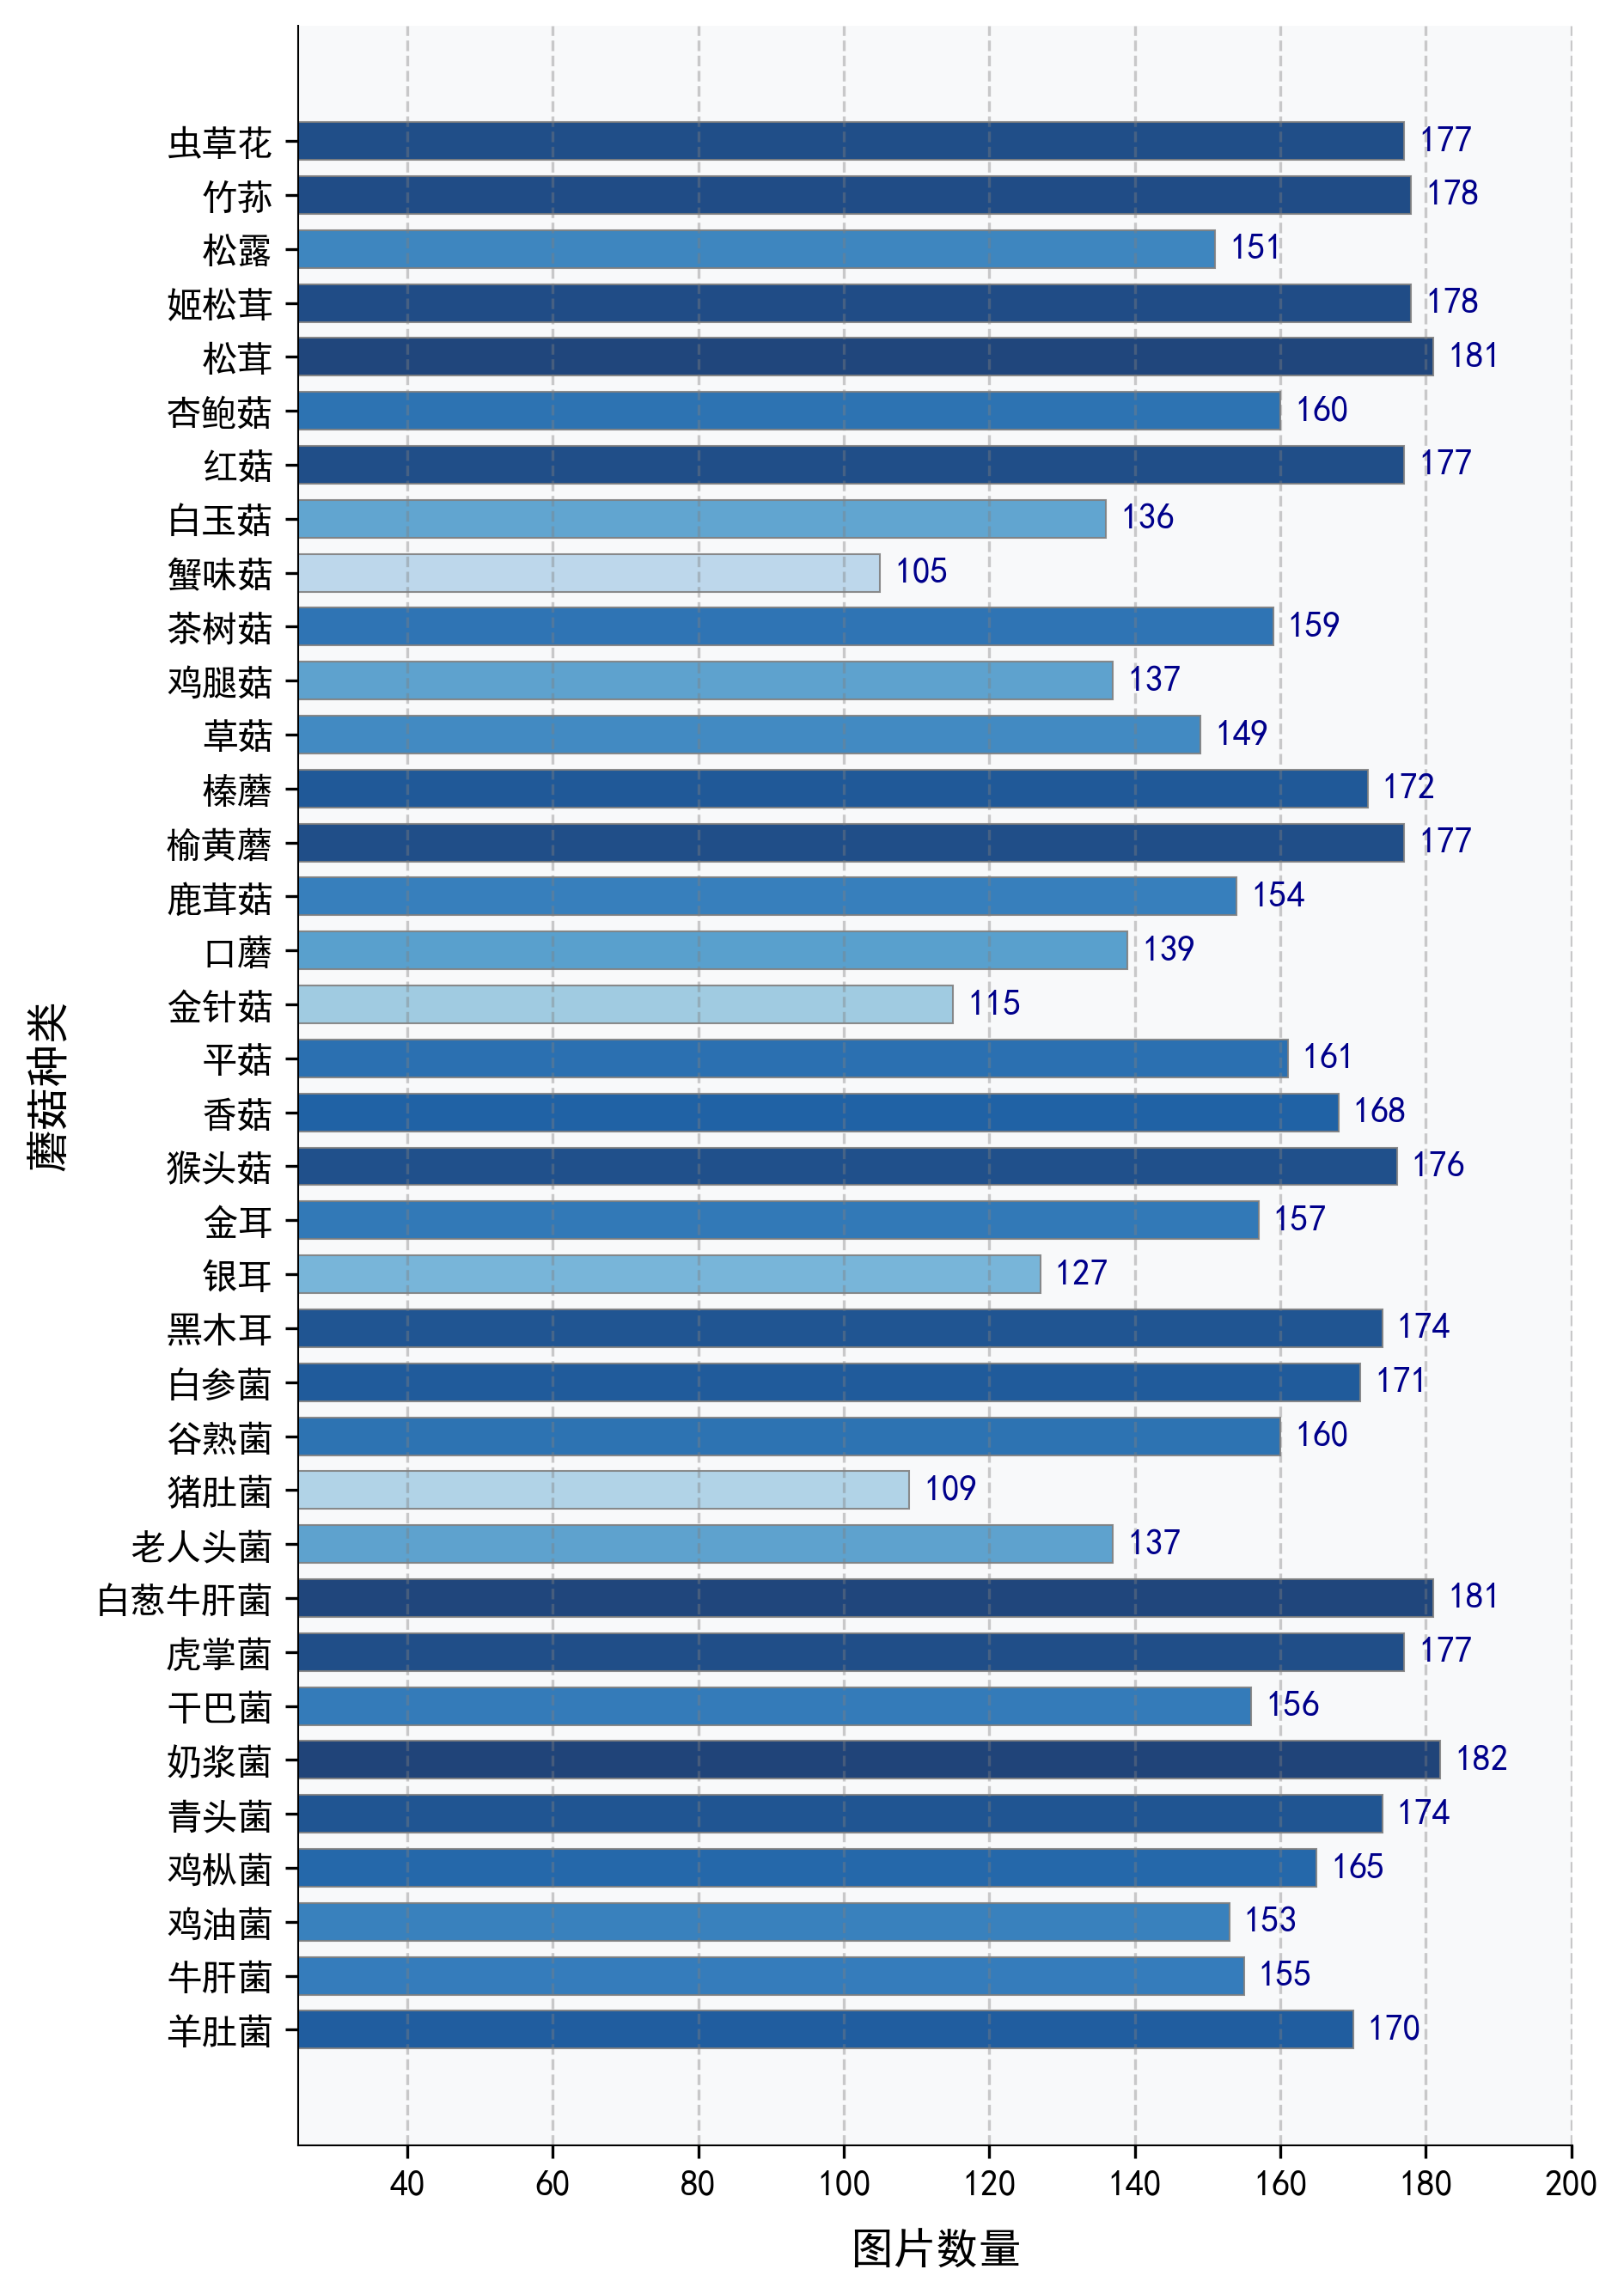

In [26]:
# 准备数据
categories_readable = list(category_counts.keys())  # 获取所有蘑菇种类名称
counts = list(category_counts.values())  # 获取每个种类对应的图片数量

# 创建一个新的图形，设置更大的尺寸以便更好地展示数据
plt.figure(figsize=(6.4, 9))

# 创建颜色渐变 - 根据数量排序，数量越多颜色越亮
# 首先创建数量和类别的映射关系
count_category_pairs = list(zip(counts, categories_readable))
# 按照数量排序
count_category_pairs.sort(key=lambda x: x[0])
# 提取排序后的类别和数量
sorted_categories = [pair[1] for pair in count_category_pairs]
sorted_counts = [pair[0] for pair in count_category_pairs]

# 创建颜色映射，使用较为柔和的颜色差异
# 使用单一色系的渐变，减小颜色差异
norm = plt.Normalize(min(counts), max(counts))
# 使用Blues色系，颜色差异较小
colors = plt.cm.Blues(norm(counts) * 0.7 + 0.3)  # 缩小颜色范围，增加最小值，减小颜色差异

# 绘制水平柱状图，使用柔和的颜色
bars = plt.barh(categories_readable, counts, color=colors, height=0.7,
                edgecolor='gray', linewidth=0.5, alpha=0.9)  # 增加透明度使颜色更柔和

# 在每个柱子右侧添加数值标签
for i, bar in enumerate(bars):
    width = bar.get_width()  # 获取柱子的宽度(即图片数量)
    plt.text(width + 2, bar.get_y() + bar.get_height()/2, f'{int(width)}',
             va='center', ha='left', fontsize=10, fontweight='bold',
             color='darkblue')  # 美化标签样式

# 设置图表标题和轴标签
plt.xlabel('图片数量', fontsize=12, labelpad=8)  # 设置x轴标签并增加内边距
plt.ylabel('蘑菇种类', fontsize=12, labelpad=8)  # 设置y轴标签并增加内边距

# 设置坐标轴样式
plt.tick_params(axis='both', which='major', labelsize=10)  # 增大刻度标签字体
plt.xlim(25, max(counts) + max(counts)*0.1)  # 设置x轴范围，留出更多空间

# 添加网格线
plt.grid(axis='x', linestyle='--', alpha=0.4, color='gray')  # 使用更淡的网格线

# 添加背景色
plt.gca().set_facecolor('#f8f9fa')  # 设置浅灰色背景
plt.gca().spines['top'].set_visible(False)  # 移除上边框
plt.gca().spines['right'].set_visible(False)  # 移除右边框
plt.gca().spines['left'].set_linewidth(0.5)  # 减小左边框宽度
plt.gca().spines['bottom'].set_linewidth(0.5)  # 减小下边框宽度

# 自动调整布局，防止标签被截断
plt.tight_layout()

# 保存图表到img目录，使用更高质量的设置
plt.savefig('img/mushroom_distribution.png',
            bbox_inches='tight',
            dpi=800,
            facecolor='#f8f9fa')  # 保存高质量图片，保持背景色一致

# 显示图形
plt.show()

# 训练准备工作

## 加载图像数据集

使用 TensorFlow 的 [image_dataset_from_directory](https://tensorflow.google.cn/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory?hl=en) 函数加载和准备图像数据集：


*   directory=dataset_path ：指定图像数据所在的路径。
*   image_size=(224, 224) ：指定每个图像的大小为224x224像素。
*   batch_size=32 ：指定每个批次包含32张图像。
*   validation_split=0.2 ：指定20%的数据作为验证集。
*   subset='both' ：指定同时返回训练集和验证集。
*   label_mode='categorical' ：指定标签模式为分类模式，返回one-hot编码的标签。
*   seed=66 ：设置随机种子以确保数据集的可重复性。

In [45]:
# 加载和准备图像数据集
train_dataset, validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=dataset_path,
    image_size=(224, 224),
    batch_size=32,
    validation_split=0.2,
    subset='both',
    label_mode='categorical',
    seed=66
)

Found 5698 files belonging to 36 classes.
Using 4559 files for training.
Using 1139 files for validation.


## 计算训练集和验证集中各类别图像的分布情况

下面我们将统计训练集和验证集中每个蘑菇类别的图像数量，以便了解数据集的分布特征。

In [28]:
# 获取类别名称
class_names = train_dataset.class_names
# 从训练数据集中获取所有类别的名称列表

# 初始化字典用于存储每种类别的图像数量
train_category_counts = {name: 0 for name in categories.values()}
validation_category_counts = {name: 0 for name in categories.values()}
# 创建两个字典，分别用于存储训练集和验证集中每个类别的图像数量
# 使用字典推导式初始化，键为类别的中文名称，值初始化为0

# 统计训练集中的图像数量
for images, labels in train_dataset:
    # 遍历训练数据集中的每个批次，每个批次包含图像和对应的标签
    for label in labels.numpy():
        # 将标签张量转换为numpy数组并遍历
        category_name = class_names[np.argmax(label)]
        # np.argmax(label)找出one-hot编码中值为1的索引位置
        # 通过索引从class_names中获取对应的类别名称
        train_category_counts[categories[category_name]] += 1
        # 将该类别在训练集中的计数加1，使用categories字典将英文名映射为中文名

# 统计验证集中的图像数量
for images, labels in validation_dataset:
    # 遍历验证数据集中的每个批次
    for label in labels.numpy():
        # 同样处理验证集中的标签
        category_name = class_names[np.argmax(label)]
        validation_category_counts[categories[category_name]] += 1
        # 将该类别在验证集中的计数加1

# 打印统计结果
print("训练集类别图像数量统计:", train_category_counts)
print("验证集类别图像数量统计:", validation_category_counts)
# 输出训练集和验证集中各个类别的图像数量统计结果

训练集类别图像数量统计: {'羊肚菌': 116, '牛肝菌': 117, '鸡油菌': 105, '鸡枞菌': 121, '青头菌': 117, '奶浆菌': 125, '干巴菌': 99, '虎掌菌': 110, '白葱牛肝菌': 135, '老人头菌': 91, '猪肚菌': 71, '谷熟菌': 109, '白参菌': 125, '黑木耳': 121, '银耳': 88, '金耳': 105, '猴头菇': 122, '香菇': 117, '平菇': 110, '金针菇': 74, '口蘑': 100, '鹿茸菇': 110, '榆黄蘑': 131, '榛蘑': 115, '草菇': 109, '鸡腿菇': 101, '茶树菇': 121, '蟹味菇': 77, '白玉菇': 97, '红菇': 125, '杏鲍菇': 108, '松茸': 133, '姬松茸': 135, '松露': 94, '竹荪': 128, '虫草花': 127}
验证集类别图像数量统计: {'羊肚菌': 54, '牛肝菌': 38, '鸡油菌': 48, '鸡枞菌': 44, '青头菌': 57, '奶浆菌': 57, '干巴菌': 57, '虎掌菌': 67, '白葱牛肝菌': 46, '老人头菌': 46, '猪肚菌': 38, '谷熟菌': 51, '白参菌': 46, '黑木耳': 53, '银耳': 39, '金耳': 52, '猴头菇': 54, '香菇': 51, '平菇': 51, '金针菇': 41, '口蘑': 39, '鹿茸菇': 44, '榆黄蘑': 46, '榛蘑': 57, '草菇': 40, '鸡腿菇': 36, '茶树菇': 38, '蟹味菇': 28, '白玉菇': 39, '红菇': 52, '杏鲍菇': 52, '松茸': 48, '姬松茸': 43, '松露': 57, '竹荪': 50, '虫草花': 50}


## 显示数据集中的图像样本

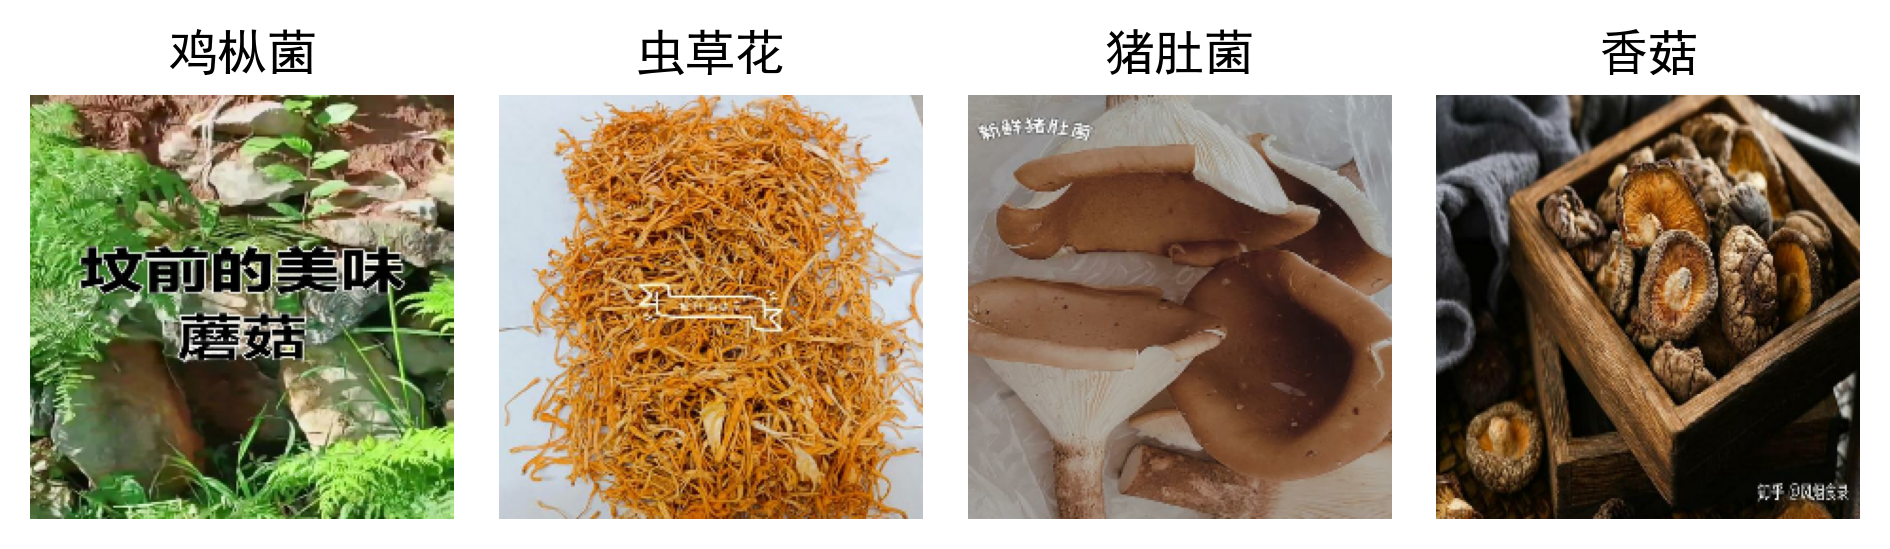

In [29]:
# 获取训练数据集中的类别名称
class_names = train_dataset.class_names

# 设置要在图中显示的随机样本图像数量
num_images_to_show = 4

# 初始化存储图像和标签的列表
images_to_display = []  # 用于存储待显示的图像
labels_to_display = []  # 用于存储对应的标签

# 从训练数据集中随机抽取一批数据
for images, labels in train_dataset.take(1):
    # 随机选择指定数量的图像索引,不重复
    indices = np.random.choice(range(images.shape[0]),
                             num_images_to_show,
                             replace=False)

    # 根据随机索引获取对应的图像和标签
    for index in indices:
        images_to_display.append(images[index])
        labels_to_display.append(labels[index])

# 创建1行num_images_to_show列的子图网格
fig, axes = plt.subplots(1, num_images_to_show, figsize=(6.4, 4))

# 遍历显示每张图像
for i, (image, label) in enumerate(zip(images_to_display, labels_to_display)):
    ax = axes[i]
    # 将图像数据转换为uint8类型并显示
    ax.imshow(image.numpy().astype("uint8"))
    # 设置图像标题为对应的蘑菇类别名称
    ax.set_title(categories[class_names[np.argmax(label.numpy())]],
                fontsize=12)
    # 关闭坐标轴显示
    ax.axis("off")

# 自动调整子图之间的间距
plt.tight_layout()

# 保存图形
plt.savefig('img/mushroom_samples.png', dpi=800, bbox_inches='tight')

# 显示整个图形
plt.show()

# 数据增强

数据增强是一种常用的技术，用于通过变换现有数据来增加训练数据的多样性，从而提高模型的泛化能力。在图像处理中，常见的数据增强技术包括旋转、翻转、缩放、裁剪、亮度调整等。

## 定义数据增强层

In [30]:
# 定义数据增强的预处理层
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),  # 水平翻转
    tf.keras.layers.RandomRotation(0.2),       # 随机旋转最多20%
    tf.keras.layers.RandomZoom(0.2, 0.2),      # 随机缩放
    tf.keras.layers.RandomContrast(0.2),       # 随机对比度调整
    tf.keras.layers.RandomBrightness(0.2)      # 随机亮度调整
])

## 定义显示数据增强示例函数

In [31]:
def demo_augmentation(sample_image, model, num_aug):
    '''接收单个图像数组，然后使用模型生成num_aug个数据增强变换'''

    # 初始化预览图像列表
    image_preview = []

    # 将输入图像转换为PIL图像实例
    sample_image_pil = tf.keras.utils.array_to_img(sample_image)

    # 将原始图像添加到列表中
    image_preview.append(sample_image_pil)

    # 应用图像增强并将结果添加到列表中
    for i in range(NUM_AUG):
        # 扩展维度以适应模型输入
        sample_image_aug = model(tf.expand_dims(sample_image, axis=0))
        # 将增强后的图像转换为PIL格式
        sample_image_aug_pil = tf.keras.utils.array_to_img(tf.squeeze(sample_image_aug))
        image_preview.append(sample_image_aug_pil)

    # 创建子图布局
    fig, axes = plt.subplots(1, NUM_AUG + 1, figsize=(6.4, 4))

    # 显示所有图像
    for index, ax in enumerate(axes):
        ax.imshow(image_preview[index])
        ax.set_axis_off()

        # 设置图像标题
        if index == 0:
            ax.set_title('原始图像')
        else:
            ax.set_title(f'增强样本 {index}')

## 获取随机批次

In [32]:
# 获取训练集中随机的一批次图片
sample_batch = list(train_dataset.take(1))[0][0]
print(f'images per batch: {len(sample_batch)}')

images per batch: 32


## 显示数据增强示例

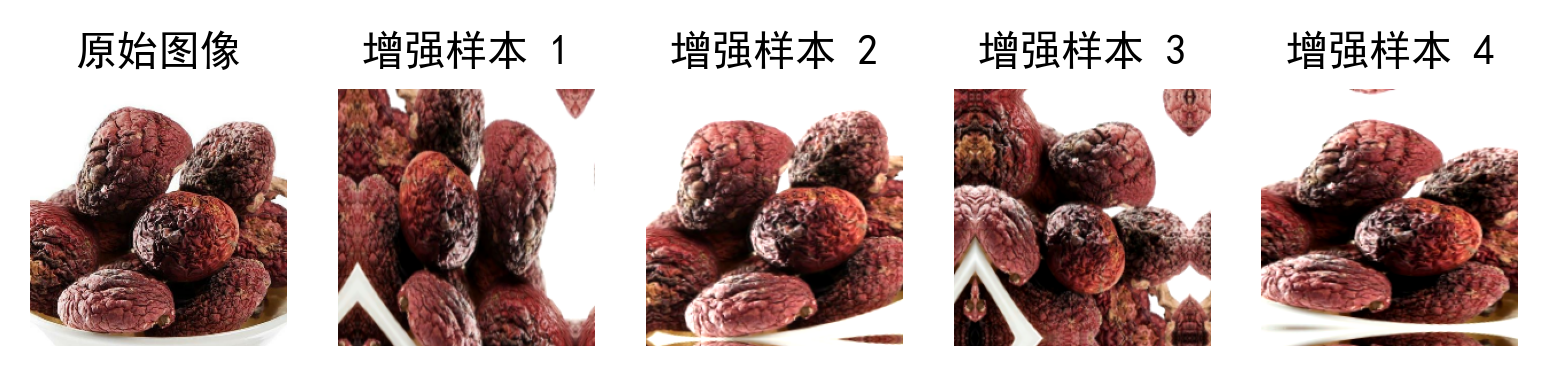

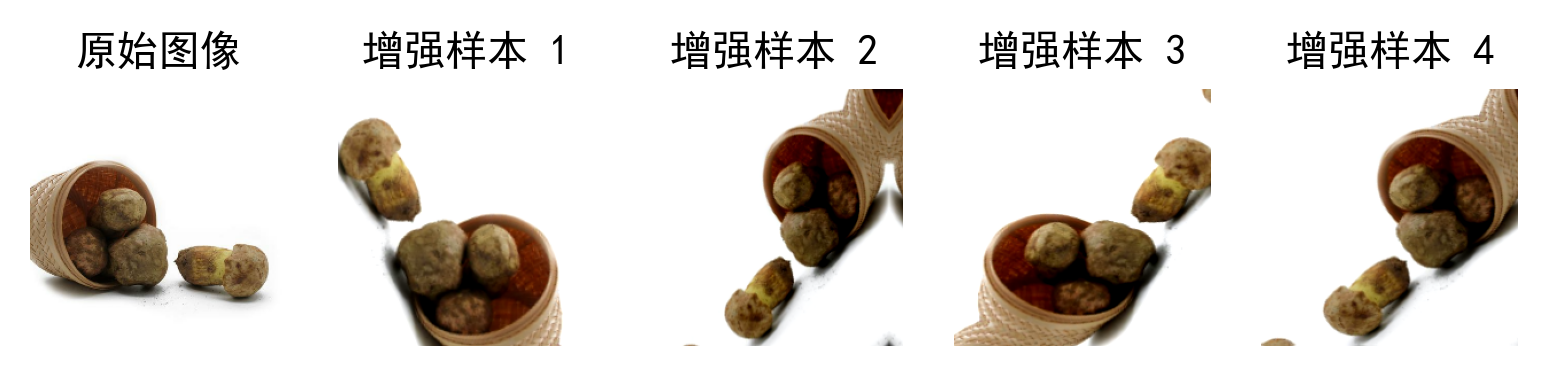

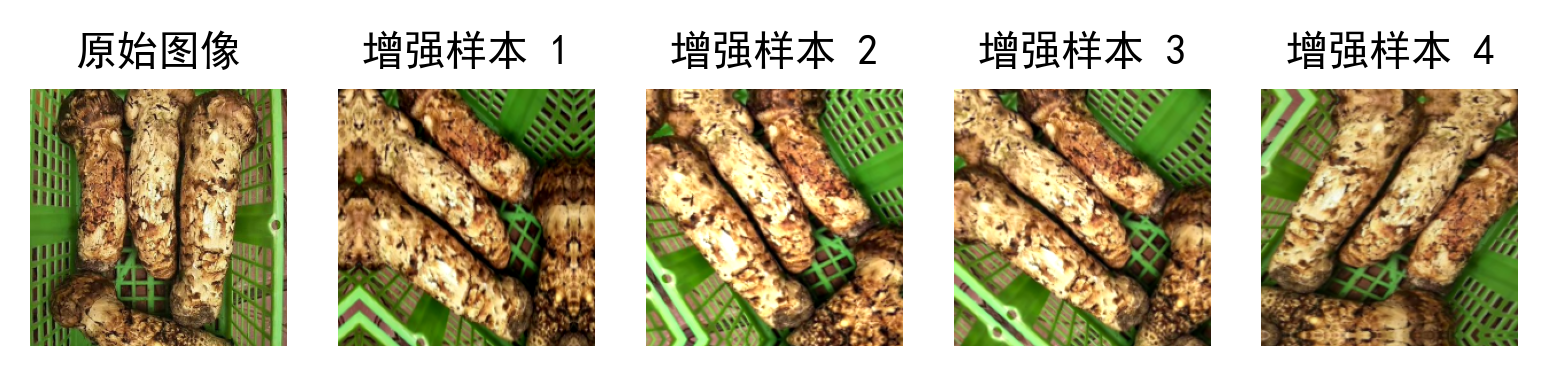

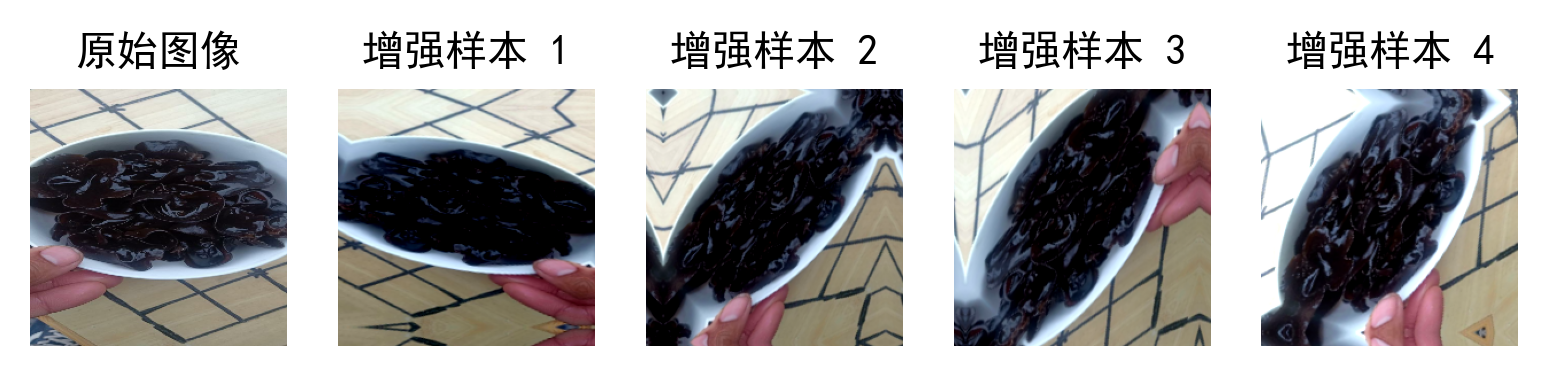

In [33]:
# 设置每个样本的数据增强次数
NUM_AUG = 4

# 对训练集中前4张图片进行数据增强演示
# 使用demo_augmentation函数对每张图片进行NUM_AUG次数据增强
# 并将原始图片和增强后的图片并排显示
demo_augmentation(sample_batch[0], data_augmentation, NUM_AUG)  # 处理第1张图片
demo_augmentation(sample_batch[1], data_augmentation, NUM_AUG)  # 处理第2张图片
demo_augmentation(sample_batch[2], data_augmentation, NUM_AUG)  # 处理第3张图片
demo_augmentation(sample_batch[3], data_augmentation, NUM_AUG)  # 处理第4张图片

# 模型训练相关函数定义
以下定义了用于模型训练的核心函数,包括:
- train_model: 训练深度学习模型的主函数,负责模型编译、配置回调函数和训练过程
- 回调函数:
  - early_stopping: 提前停止训练,防止过拟合
  - lr_scheduler: 动态调整学习率,优化训练效果
- 训练参数:
  - optimizer: adam优化器
  - loss: 分类交叉熵损失函数
  - metrics: 准确率评估指标

In [43]:
# 训练模型函数
def train_model(model, train_dataset=train_dataset, validation_dataset=validation_dataset, epochs=40):
    """
    训练深度学习模型的函数

    参数:
        model: 待训练的模型
        train_dataset: 训练数据集
        validation_dataset: 验证数据集
        epochs: 训练轮数,默认30轮

    返回:
        history: 训练历史记录,包含loss和accuracy等指标
    """
    # 配置模型训练参数
    # 使用adam优化器,交叉熵损失函数,准确率评估指标
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    # 配置回调函数
    # early_stopping: 当验证集loss在6轮内没有改善时停止训练,并恢复最佳权重
    """
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=6,
        restore_best_weights=True
    )
    """

    # lr_scheduler: 当验证集loss在3轮内没有改善时,学习率减半,最小到1e-7
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-7
    )

    # 开始训练
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=validation_dataset,
        callbacks=[lr_scheduler]
    )

    return history

# 模型量化和保存

为了在移动设备和嵌入式系统上高效部署模型,我们需要:
1. 将训练好的Keras模型量化 - 把权重从float32转为int8,显著减小模型大小
2. 转换为TFLite格式 - TFLite是专门为移动和嵌入式设备优化的轻量级框架
3. 保存模型到文件 - 以便后续部署使用

下面三个函数实现了这些功能:
- convert_to_tflite(): 将Keras模型转换为TFLite格式
- quantize_and_convert_to_tflite(): 模型量化和TFLite转换
- save_model(): 保存模型到文件


In [35]:
def convert_to_tflite(model):
    """
    将Keras模型转换为TFLite格式

    参数:
        model: Keras模型对象

    返回:
        tflite_model: 转换后的TFLite模型

    说明:
        - 使用TFLite转换器将Keras模型转换为TFLite格式
    """
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    return tflite_model

def quantize_and_convert_to_tflite(model):
    """
    将Keras模型量化并转换为TFLite格式

    参数:
        model: Keras模型对象

    返回:
        tflite_quant_model: 量化后的TFLite模型

    说明:
        - 使用TFLite转换器将Keras模型转换为TFLite格式
        - 启用默认优化以减小模型大小和提高推理性能
        - 量化可以将模型权重从float32转换为int8,显著减小模型大小
    """
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_quant_model = converter.convert()

    return tflite_quant_model

def save_model(model, output_path):
    """
    保存模型到文件

    参数:
        model: 要保存的模型对象
        output_path: 保存模型的文件路径

    说明:
        - 以二进制格式写入模型到指定路径
        - 通常用于保存TFLite模型(.tflite文件)
    """
    with open(output_path, 'wb') as f:
        f.write(model)

可视化训练历史

下面的函数用于可视化模型训练过程中的指标变化:

- show_history(): 绘制训练历史中的损失和准确率曲线
  - 创建1x2的子图布局
  - 左图显示训练和验证损失
  - 右图显示训练和验证准确率
  - 使用matplotlib进行绘图



In [36]:
def show_history(history):
    """
    可视化模型训练历史中的损失和准确率曲线

    参数:
        history: 模型训练返回的History对象,包含训练过程中的指标数据

    功能:
        - 创建一个1x2的子图布局
        - 左图显示训练集和验证集的损失曲线
        - 右图显示训练集和验证集的准确率曲线
        - 自动调整布局并显示图形

    返回:
        无返回值,直接显示图形
    """
    # 创建12x4英寸的画布
    plt.figure(figsize=(6.4, 5))

    # 绘制损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # 绘制准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # 自动调整子图布局
    plt.tight_layout()
    # 显示图形
    plt.show()

In [37]:
def evaluate_model(model, dataset):
    """使用TensorFlow内置metrics评估Keras模型在数据集上的性能

    Args:
        model: Keras模型对象
        dataset: tf.data.Dataset数据集对象

    Returns:
        tuple: (top1准确率, top5准确率, 模型大小, 推理速度)
    """
    # 计算模型大小 (MB)
    model_size_mb = sum(np.prod(w.shape) for w in model.get_weights()) * 4 / (1024 * 1024)

    # 创建评估指标
    top1_accuracy = tf.keras.metrics.CategoricalAccuracy()  # Top-1准确率评估器
    top5_accuracy = tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top5_accuracy')  # Top-5准确率评估器

    # 创建损失函数和平均损失计算器
    loss_object = tf.keras.losses.CategoricalCrossentropy()  # 分类交叉熵损失函数
    loss_avg = tf.keras.metrics.Mean()  # 用于计算平均损失

    # 记录推理时间
    total_time = 0
    total_samples = 0

    # 在数据集上运行评估
    for images, labels in dataset:
        start_time = time.time()
        predictions = model(images, training=False)  # 获取模型预测结果
        end_time = time.time()

        # 累计推理时间和样本数
        total_time += end_time - start_time
        total_samples += len(images)

        loss = loss_object(labels, predictions)  # 计算损失值

        # 更新评估指标
        loss_avg.update_state(loss)
        top1_accuracy.update_state(labels, predictions)
        top5_accuracy.update_state(labels, predictions)

    # 计算平均推理速度 (ms/sample)
    avg_inference_time = (total_time / total_samples) * 1000

    # 获取最终评估结果
    loss = loss_avg.result().numpy()
    top1 = top1_accuracy.result().numpy()
    top5 = top5_accuracy.result().numpy()

    # 打印评估结果
    print(f"Loss: {loss:.4f}")
    print(f"Top-1 Accuracy: {top1:.4f}")
    print(f"Top-5 Accuracy: {top5:.4f}")
    print(f"Model Size: {model_size_mb:.2f} MB")
    print(f"Average Inference Time: {avg_inference_time:.2f} ms/sample")

    return top1, top5, model_size_mb, avg_inference_time

def evaluate_tflite_model(tflite_model, dataset):
    """评估TFLite模型的性能

    Args:
        tflite_model: TFLite模型的二进制内容
        dataset: tf.data.Dataset数据集对象

    Returns:
        tuple: (top1准确率, top5准确率, 模型大小, 推理速度)
    """
    # 计算TFLite模型大小 (MB)
    model_size_mb = len(tflite_model) / (1024 * 1024)

    # 创建并初始化TFLite解释器
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()

    # 获取模型输入输出张量的详细信息
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # 创建评估指标
    top1_accuracy = tf.keras.metrics.Accuracy()  # Top-1准确率评估器
    top5_accuracy = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)  # Top-5准确率评估器

    total_samples = 0  # 样本计数器
    total_time = 0  # 总推理时间

    # 遍历数据集进行评估
    for images, labels in dataset:
        # 将one-hot标签转换为类别索引
        true_labels = tf.argmax(labels, axis=1).numpy()

        batch_size = images.shape[0]
        # 存储批次预测结果的数组
        batch_predictions = np.zeros((batch_size, len(class_names)), dtype=np.float32)

        # 对批次中的每个样本进行推理
        for i in range(batch_size):
            total_samples += 1

            # 预处理输入数据
            input_data = np.expand_dims(images[i].numpy(), axis=0).astype(np.float32)

            # 记录推理时间
            start_time = time.time()

            # 设置输入数据并运行推理
            interpreter.set_tensor(input_details[0]['index'], input_data)
            interpreter.invoke()

            # 获取预测结果
            batch_predictions[i] = interpreter.get_tensor(output_details[0]['index'])[0]

            end_time = time.time()
            total_time += end_time - start_time

        # 更新评估指标
        top1_accuracy.update_state(
            true_labels,
            np.argmax(batch_predictions, axis=1)
        )
        top5_accuracy.update_state(
            true_labels,
            batch_predictions
        )

    # 计算平均推理速度 (ms/sample)
    avg_inference_time = (total_time / total_samples) * 1000

    # 获取最终评估结果
    top1 = top1_accuracy.result().numpy()
    top5 = top5_accuracy.result().numpy()

    # 打印评估结果
    print(f"TFLite模型 Top-1 准确率: {top1:.4f}")
    print(f"TFLite模型 Top-5 准确率: {top5:.4f}")
    print(f"TFLite模型大小: {model_size_mb:.2f} MB")
    print(f"TFLite模型平均推理时间: {avg_inference_time:.2f} ms/sample")

    return top1, top5, model_size_mb, avg_inference_time

# MobileNetV1模型

In [38]:
def get_MobileNetV1():
  """
  构建并返回一个基于MobileNetV1的迁移学习模型

  模型架构:
  1. 使用预训练的MobileNetV1作为特征提取器
  2. 添加数据增强层进行训练时的数据增强
  3. 添加预处理层对输入进行标准化
  4. 添加自定义分类器头部进行具体任务的分类

  返回:
  - 构建好的MobileNetV1模型
  """
  # 初始化基础模型 - 使用ImageNet预训练权重,不包含顶层分类器
  pre_trained_model = tf.keras.applications.MobileNet(
      input_shape=(224, 224, 3),  # 输入图像尺寸为224x224,3通道
      include_top=False,  # 不包含顶层分类器
      weights='imagenet'  # 加载ImageNet预训练权重
  )

  # 冻结基础模型的权重 - 固定特征提取器,只训练新添加的分类层
  for layer in pre_trained_model.layers:
      layer.trainable = False

  # 应用数据增强和预处理
  x = data_augmentation(pre_trained_model.input)  # 添加数据增强提高模型泛化能力
  x = tf.keras.applications.mobilenet.preprocess_input(x)  # MobileNet专用的预处理方法

  # 添加自定义顶层分类器
  x = pre_trained_model(x)  # 通过预训练模型提取特征
  x = tf.keras.layers.GlobalAveragePooling2D()(x)  # 全局平均池化减少参数量
  x = tf.keras.layers.Dropout(0.5)(x)  # dropout层防止过拟合
  x = tf.keras.layers.Dense(128, activation='relu')(x)  # 全连接层
  x = tf.keras.layers.Dense(256, activation='relu')(x)  # 全连接层增加非线性
  predictions = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)  # 输出层,使用softmax进行多分类

  # 构建最终模型 - 将输入和输出组装成完整的模型
  MobileNetV1 = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=predictions)

  return MobileNetV1

# MobileNetV2模型

In [39]:
def get_MobileNetV2():
  """
  构建并返回一个基于MobileNetV2的迁移学习模型

  模型架构:
  1. 使用预训练的MobileNetV2作为特征提取器
  2. 添加数据增强层进行训练时的数据增强
  3. 添加预处理层对输入进行标准化
  4. 添加自定义分类器头部进行具体任务的分类

  返回:
  - 构建好的MobileNetV2模型
  """
  # 初始化基础模型 - 使用ImageNet预训练权重,不包含顶层分类器
  pre_trained_model = tf.keras.applications.MobileNetV2(
      input_shape=(224, 224, 3),  # 输入图像尺寸为224x224,3通道
      include_top=False,  # 不包含顶层分类器
      weights='imagenet'  # 加载ImageNet预训练权重
  )

  # 冻结基础模型的权重 - 固定特征提取器,只训练新添加的分类层
  for layer in pre_trained_model.layers:
      layer.trainable = False

  # 应用数据增强和预处理
  x = data_augmentation(pre_trained_model.input)  # 添加数据增强提高模型泛化能力
  x = tf.keras.applications.mobilenet_v2.preprocess_input(x)  # MobileNetV2专用的预处理方法

  # 添加自定义顶层分类器
  x = pre_trained_model(x)  # 通过预训练模型提取特征
  x = tf.keras.layers.GlobalAveragePooling2D()(x)  # 全局平均池化减少参数量
  x = tf.keras.layers.Dropout(0.5)(x)  # dropout层防止过拟合
  x = tf.keras.layers.Dense(128, activation='relu')(x)  # 全连接层
  x = tf.keras.layers.Dense(256, activation='relu')(x)  # 全连接层增加非线性
  predictions = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)  # 输出层,使用softmax进行多分类

  # 构建最终模型 - 将输入和输出组装成完整的模型
  MobileNetV2 = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=predictions)

  return MobileNetV2

# EfficientNet模型

In [40]:
def get_EfficientNetB0():
  """
  构建并返回一个基于EfficientNetB0的迁移学习模型

  模型架构:
  1. 使用预训练的EfficientNetB0作为特征提取器,该模型在ImageNet数据集上预训练
  2. 添加数据增强层提高模型泛化能力
  3. 添加预处理层对输入进行标准化
  4. 添加自定义分类器头部进行具体任务的分类

  返回:
  - 构建好的EfficientNetB0模型
  """
  # 初始化基础模型 - 使用ImageNet预训练权重,不包含顶层分类器
  pre_trained_model = tf.keras.applications.EfficientNetB0(
      input_shape=(224, 224, 3),  # 输入图像尺寸为224x224,3通道
      include_top=False,  # 不包含顶层分类器
      weights='imagenet'  # 加载ImageNet预训练权重
  )

  # 冻结基础模型的权重 - 固定特征提取器,只训练新添加的分类层
  for layer in pre_trained_model.layers:
      layer.trainable = False

  # 应用数据增强和预处理
  x = data_augmentation(pre_trained_model.input)  # 添加数据增强提高模型泛化能力
  x = tf.keras.applications.efficientnet.preprocess_input(x)  # EfficientNet专用的预处理方法

  # 添加自定义顶层分类器
  x = pre_trained_model(x)  # 通过预训练模型提取特征
  x = tf.keras.layers.GlobalAveragePooling2D()(x)  # 全局平均池化减少参数量
  x = tf.keras.layers.Dropout(0.5)(x)  # dropout层防止过拟合
  x = tf.keras.layers.Dense(128, activation='relu')(x)  # 全连接层
  x = tf.keras.layers.Dense(256, activation='relu')(x)  # 全连接层增加非线性
  predictions = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)  # 输出层,使用softmax进行多分类

  # 构建最终模型 - 将输入和输出组装成完整的模型
  EfficientNetB0 = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=predictions)

  return EfficientNetB0

# ResNet模型

In [41]:
def get_ResNet101():
  """
  构建并返回一个基于ResNet101的迁移学习模型

  模型架构:
  1. 使用预训练的ResNet101作为特征提取器,该模型在ImageNet数据集上预训练
  2. 添加数据增强层提高模型泛化能力
  3. 添加预处理层对输入进行标准化
  4. 添加自定义分类器头部进行具体任务的分类

  返回:
  - 构建好的ResNet101模型
  """
  # 初始化基础模型 - 使用ImageNet预训练权重,不包含顶层分类器
  pre_trained_model = tf.keras.applications.ResNet101(
      input_shape=(224, 224, 3),  # 输入图像尺寸为224x224,3通道
      include_top=False,  # 不包含顶层分类器
      weights='imagenet'  # 加载ImageNet预训练权重
  )

  # 冻结基础模型的权重 - 固定特征提取器,只训练新添加的分类层
  for layer in pre_trained_model.layers:
      layer.trainable = False

  # 应用数据增强和预处理
  x = data_augmentation(pre_trained_model.input)  # 添加数据增强提高模型泛化能力
  x = tf.keras.applications.resnet.preprocess_input(x)  # ResNet专用的预处理方法

  # 添加自定义顶层分类器
  x = pre_trained_model(x)  # 通过预训练模型提取特征
  x = tf.keras.layers.GlobalAveragePooling2D()(x)  # 全局平均池化减少参数量
  x = tf.keras.layers.Dropout(0.5)(x)  # dropout层防止过拟合
  x = tf.keras.layers.Dense(128, activation='relu')(x)  # 全连接层
  x = tf.keras.layers.Dense(256, activation='relu')(x)  # 全连接层增加非线性
  predictions = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)  # 输出层,使用softmax进行多分类

  # 构建最终模型 - 将输入和输出组装成完整的模型
  ResNet101 = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=predictions)

  return ResNet101

# 训练

In [46]:
# 获取MobileNetV1模型
MobileNetV1 = get_MobileNetV1()

# 训练MobileNetV1模型并保存训练历史
history_MobileNetV1 = train_model(MobileNetV1)

# 模型转换为TFLite格式
MobileNetV1_tflite = convert_to_tflite(MobileNetV1)

# 将模型量化并转换为TFLite格式以便部署
MobileNetV1_quantize_tflite = quantize_and_convert_to_tflite(MobileNetV1)

Epoch 1/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - accuracy: 0.0998 - loss: 3.4224 - val_accuracy: 0.3915 - val_loss: 2.1131 - learning_rate: 0.0010
Epoch 2/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - accuracy: 0.3600 - loss: 2.2043 - val_accuracy: 0.5524 - val_loss: 1.5995 - learning_rate: 0.0010
Epoch 3/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - accuracy: 0.4919 - loss: 1.8119 - val_accuracy: 0.5775 - val_loss: 1.4608 - learning_rate: 0.0010
Epoch 4/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step - accuracy: 0.5187 - loss: 1.6538 - val_accuracy: 0.5916 - val_loss: 1.3800 - learning_rate: 0.0010
Epoch 5/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 126ms/step - accuracy: 0.5398 - loss: 1.6080 - val_accuracy: 0.6325 - val_loss: 1.2887 - learning_rate: 0.0010
Epoch 6/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 123ms/step - accuracy: 0.5584 - loss: 1.5137 - val_accuracy: 0.6331 - val_loss: 1.2855 - learning_rate: 0.0010
Epoch 7/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - accuracy: 0.5

In [47]:
# 获取MobileNetV2模型
MobileNetV2 = get_MobileNetV2()

# 训练MobileNetV2模型并保存训练历史
history_MobileNetV2 = train_model(MobileNetV2)

# 模型转换为TFLite格式
MobileNetV2_tflite = convert_to_tflite(MobileNetV2)

# 将模型量化并转换为TFLite格式以便部署
MobileNetV2_quantize_tflite = quantize_and_convert_to_tflite(MobileNetV2)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 138ms/step - accuracy: 0.1300 - loss: 3.3141 - val_accuracy: 0.4886 - val_loss: 1.8403 - learning_rate: 0.0010
Epoch 2/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 128ms/step - accuracy: 0.4398 - loss: 1.9358 - val_accuracy: 0.5764 - val_loss: 1.5043 - learning_rate: 0.0010
Epoch 3/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 123ms/step - accuracy: 0.5236 - loss: 1.6599 - val_accuracy: 0.6027 - val_loss: 1.3609 - learning_rate: 0.0010
Epoch 4/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 26s 172ms/step - accuracy: 0.5633 - loss: 1.4549 - val_accuracy: 0.6437 - val_loss: 1.2513 - learning_rate: 0.0010
Epoch 5/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - accuracy: 0.5906 - loss: 1.3939 - val_accuracy: 0.6407 - val_loss: 1.2802 - learning_rate: 0.0010
Epoch 6/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step - accuracy: 0.6198 - loss: 1.2878 - val_accuracy: 0.6618 - val_loss: 1.2219 - learning_rate: 0.0010
Epoch 7/40
125/125 ━━

In [48]:
# 获取EfficientNetB0模型
EfficientNetB0 = get_EfficientNetB0()

# 训练EfficientNetB0模型并保存训练历史
history_EfficientNetB0 = train_model(EfficientNetB0)

# 模型转换为TFLite格式
EfficientNetB0_tflite = convert_to_tflite(EfficientNetB0)

# 将模型量化并转换为TFLite格式以便部署
EfficientNetB0_quantize_tflite = quantize_and_convert_to_tflite(EfficientNetB0)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 153ms/step - accuracy: 0.1569 - loss: 3.2140 - val_accuracy: 0.5319 - val_loss: 1.6314 - learning_rate: 0.0010
Epoch 2/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 0.5157 - loss: 1.7226 - val_accuracy: 0.6583 - val_loss: 1.2072 - learning_rate: 0.0010
Epoch 3/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 173ms/step - accuracy: 0.5921 - loss: 1.3745 - val_accuracy: 0.6910 - val_loss: 1.1081 - learning_rate: 0.0010
Epoch 4/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - accuracy: 0.6343 - loss: 1.2391 - val_accuracy: 0.7180 - val_loss: 1.0279 - learning_rate: 0.0010
Epoch 5/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.6536 - loss: 1.1827 - val_accuracy: 0.7068 - val_loss: 1.0532 - learning_rate: 0.0010
Epoch 6/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 26s 175ms/step - accuracy: 0.6743 - loss: 1.1192 - val_accuracy: 0.7174 - val_loss: 1.0021 - learning_rate: 0.0010
Epoch 7/40
125/125 

In [ ]:
# 获取ResNet101模型
ResNet101 = get_ResNet101()

# 训练ResNet101模型并保存训练历史
history_ResNet101 = train_model(ResNet101)

# 模型转换为TFLite格式
ResNet101_tflite = convert_to_tflite(ResNet101)

# 将模型量化并转换为TFLite格式以便部署
ResNet101_quantize_tflite = quantize_and_convert_to_tflite(ResNet101)

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 68s 422ms/step - accuracy: 0.1449 - loss: 3.2644 - val_accuracy: 0.5319 - val_loss: 1.6329 - learning_rate: 0.0010
Epoch 2/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 307ms/step - accuracy: 0.4761 - loss: 1.8246 - val_accuracy: 0.6156 - val_loss: 1.3523 - learning_rate: 0.0010
Epoch 3/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 306ms/step - accuracy: 0.5425 - loss: 1.5593 - val_accuracy: 0.6208 - val_loss: 1.3418 - learning_rate: 0.0010
Epoch 4/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 50s 381ms/step - accuracy: 0.5843 - loss: 1.4077 - val_accuracy: 0.6647 - val_loss: 1.2190 - learning_rate: 0.0010
Epoch 5/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 309ms/step - accuracy: 0.6262 - loss: 1.2808 - val_accuracy: 0.6811 - val_loss: 1.1771 - learning_rate: 0.0010
Epoch 6/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 305ms/step - accuracy: 0.6280 - loss: 1.2352 - val_accuracy: 0.6770 - val_loss: 1.1725 - learning_rate: 0.0010
Epoch 7/40
125/12

In [ ]:
# 合并所有模型的训练历史数据并可视化比较

# 设置全局样式参数
TITLE_SIZE = 12
LABEL_SIZE = 10
LEGEND_SIZE = 10
LINE_WIDTH = 1
FIG_SIZE = (6.4, 4)
DPI = 600
TICK_SIZE = 8  # 新增坐标轴刻度文字大小参数


In [ ]:
# 绘制训练准确率对比
plt.figure(figsize=FIG_SIZE, dpi=DPI)
plt.plot(history_MobileNetV1.history['accuracy'], label='MobileNetV1', linewidth=LINE_WIDTH)
plt.plot(history_MobileNetV2.history['accuracy'], label='MobileNetV2', linewidth=LINE_WIDTH)
plt.plot(history_EfficientNetB0.history['accuracy'], label='EfficientNetB0', linewidth=LINE_WIDTH)
plt.plot(history_ResNet101.history['accuracy'], label='ResNet101', linewidth=LINE_WIDTH)
#plt.title('训练准确率对比', fontsize=TITLE_SIZE, pad=15, fontweight='bold')
plt.xlabel('轮次', fontsize=LABEL_SIZE)
plt.ylabel('准确率', fontsize=LABEL_SIZE)
plt.legend(fontsize=LEGEND_SIZE, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(labelsize=TICK_SIZE)  # 修改坐标轴刻度文字大小
plt.savefig('img/training_accuracy.png', dpi=DPI, bbox_inches='tight')
plt.show()

In [ ]:
# 绘制验证准确率对比
plt.figure(figsize=FIG_SIZE, dpi=DPI)
plt.plot(history_MobileNetV1.history['val_accuracy'], label='MobileNetV1', linewidth=LINE_WIDTH)
plt.plot(history_MobileNetV2.history['val_accuracy'], label='MobileNetV2', linewidth=LINE_WIDTH)
plt.plot(history_EfficientNetB0.history['val_accuracy'], label='EfficientNetB0', linewidth=LINE_WIDTH)
plt.plot(history_ResNet101.history['val_accuracy'], label='ResNet101', linewidth=LINE_WIDTH)
#plt.title('验证准确率对比', fontsize=TITLE_SIZE, pad=15, fontweight='bold')
plt.xlabel('轮次', fontsize=LABEL_SIZE)
plt.ylabel('准确率', fontsize=LABEL_SIZE)
plt.legend(fontsize=LEGEND_SIZE, loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(labelsize=TICK_SIZE)  # 修改坐标轴刻度文字大小
plt.savefig('img/validation_accuracy.png', dpi=DPI, bbox_inches='tight')
plt.show()

In [ ]:
# 绘制训练损失对比
plt.figure(figsize=FIG_SIZE, dpi=DPI)
plt.plot(history_MobileNetV1.history['loss'], label='MobileNetV1', linewidth=LINE_WIDTH)
plt.plot(history_MobileNetV2.history['loss'], label='MobileNetV2', linewidth=LINE_WIDTH)
plt.plot(history_EfficientNetB0.history['loss'], label='EfficientNetB0', linewidth=LINE_WIDTH)
plt.plot(history_ResNet101.history['loss'], label='ResNet101', linewidth=LINE_WIDTH)
#plt.title('训练损失对比', fontsize=TITLE_SIZE, pad=15, fontweight='bold')
plt.xlabel('轮次', fontsize=LABEL_SIZE)
plt.ylabel('损失', fontsize=LABEL_SIZE)
plt.legend(fontsize=LEGEND_SIZE, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(labelsize=TICK_SIZE)  # 修改坐标轴刻度文字大小
plt.savefig('img/training_loss.png', dpi=DPI, bbox_inches='tight')
plt.show()

In [ ]:
# 绘制验证损失对比
plt.figure(figsize=FIG_SIZE, dpi=DPI)
plt.plot(history_MobileNetV1.history['val_loss'], label='MobileNetV1', linewidth=LINE_WIDTH)
plt.plot(history_MobileNetV2.history['val_loss'], label='MobileNetV2', linewidth=LINE_WIDTH)
plt.plot(history_EfficientNetB0.history['val_loss'], label='EfficientNetB0', linewidth=LINE_WIDTH)
plt.plot(history_ResNet101.history['val_loss'], label='ResNet101', linewidth=LINE_WIDTH)
#plt.title('验证损失对比', fontsize=TITLE_SIZE, pad=15, fontweight='bold')
plt.xlabel('轮次', fontsize=LABEL_SIZE)
plt.ylabel('损失', fontsize=LABEL_SIZE)
plt.legend(fontsize=LEGEND_SIZE, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(labelsize=TICK_SIZE)  # 修改坐标轴刻度文字大小
plt.savefig('img/validation_loss.png', dpi=DPI, bbox_inches='tight')
plt.show()

# 评估

本节将对训练好的模型进行评估,包括:
1. 评估原始模型在验证集上的性能指标(准确率等)
2. 评估量化后的TFLite模型在验证集上的性能指标
3. 将量化后的TFLite模型保存到文件中以便部署

我们将依次评估以下4个模型:
- MobileNetV1: 轻量级CNN模型,适合移动端部署
- MobileNetV2: MobileNetV1的改进版本,性能更好
- EfficientNetB0: 高效CNN模型,在准确率和效率之间取得平衡
- ResNet101: 经典的深度残差网络,性能强大但计算量较大

In [ ]:
if not os.path.exists("models"):
    os.makedirs("models")

MobileNetV1.save("models/MobileNetV1.keras")
save_model(MobileNetV1_tflite, "models/MobileNetV1.tflite")
save_model(MobileNetV1_quantize_tflite, "models/MobileNetV1_quantize.tflite")

MobileNetV2.save("models/MobileNetV2.keras")
save_model(MobileNetV2_tflite, "models/MobileNetV2.tflite")
save_model(MobileNetV2_quantize_tflite, "models/MobileNetV2_quantize.tflite")

EfficientNetB0.save("models/EfficientNetB0.keras")
save_model(EfficientNetB0_tflite, "models/EfficientNetB0.tflite")
save_model(EfficientNetB0_quantize_tflite, "models/EfficientNetB0_quantize.tflite")

ResNet101.save("models/ResNet101.keras")
save_model(ResNet101_tflite, "models/ResNet101.tflite")
save_model(ResNet101_quantize_tflite, "model/ResNet101_quantize.tflite")

!zip -r models.zip models

In [ ]:
# 评估并保存MobileNetV1模型
print("MobileNetV1:\n")
# 评估原始模型在验证集上的性能
evaluate_model(MobileNetV1, validation_dataset)
# 评估TFLite模型在验证集上的性能
evaluate_tflite_model(MobileNetV1_tflite, validation_dataset)
# 评估量化后的量化TFLite模型在验证集上的性能
evaluate_tflite_model(MobileNetV1_quantize_tflite, validation_dataset)

# 评估并保存MobileNetV2模型
print("\nMobileNetV2:\n")
# 评估原始模型在验证集上的性能
evaluate_model(MobileNetV2, validation_dataset)
# 评估TFLite模型在验证集上的性能
evaluate_tflite_model(MobileNetV2_tflite, validation_dataset)
# 评估量化后的量化TFLite模型在验证集上的性能
evaluate_tflite_model(MobileNetV2_quantize_tflite, validation_dataset)

# 评估并保存EfficientNetB0模型
print("\nEfficientNetB0:\n")
# 评估原始模型在验证集上的性能
evaluate_model(EfficientNetB0, validation_dataset)
# 评估TFLite模型在验证集上的性能
evaluate_tflite_model(EfficientNetB0_tflite, validation_dataset)
# 评估量化后的量化TFLite模型在验证集上的性能
evaluate_tflite_model(EfficientNetB0_quantize_tflite, validation_dataset)

# 评估并保存ResNet101模型
print("\nResNet101:\n")
# 评估原始模型在验证集上的性能
evaluate_model(ResNet101, validation_dataset)
# 评估TFLite模型在验证集上的性能
evaluate_tflite_model(ResNet101_tflite, validation_dataset)
# 评估量化后的量化TFLite模型在验证集上的性能
evaluate_tflite_model(ResNet101_quantize_tflite, validation_dataset)

MobileNetV1:

Loss: 1.0806
Top-1 Accuracy: 0.7162
Top-5 Accuracy: 0.9146
Model Size: 12.98 MB
Average Inference Time: 3.75 ms/sample
TFLite模型 Top-1 准确率: 0.7162
TFLite模型 Top-5 准确率: 0.9146
TFLite模型大小: 12.87 MB
TFLite模型平均推理时间: 21.56 ms/sample
TFLite模型 Top-1 准确率: 0.7028
TFLite模型 Top-5 准确率: 0.9140
TFLite模型大小: 3.40 MB
TFLite模型平均推理时间: 27.08 ms/sample


ValueError: The filename must end in `.weights.h5`. Received: filepath=MobileNetV1_source.h5

# 使用图片测试模型

下面的代码定义了两个主要函数:
1. preprocess_image(): 图像预处理函数
   - 从URL下载图片并进行预处理
   - 调整图片大小、处理通道数等
   - 返回预处理后的图片数组和原始图片对象
2. predict_top_k_from_url(): 模型预测函数
   - 使用预处理函数处理输入图片
   - 使用模型进行预测
   - 返回前k个最可能的预测类别及其置信度


In [ ]:
# 图像预处理函数
# 输入:
#   - image_url: 图片URL链接
#   - target_size: 目标图片大小,默认(224,224)
# 输出:
#   - image_array: 预处理后的图片数组,形状为(1, height, width, channels)
#   - image: 原始PIL图片对象
def preprocess_image(image_url, target_size=(224, 224)):
    # 从URL下载图片
    response = requests.get(image_url)
    if response.status_code != 200:
        raise ValueError("无法从链接加载图像，请检查链接是否有效！")

    # 将图片转换为PIL对象并调整大小
    image = Image.open(BytesIO(response.content))
    image = image.resize(target_size)

    # 转换为numpy数组
    image_array = np.array(image)

    # 处理灰度图,转换为3通道
    if image_array.shape[-1] != 3:
        image_array = np.stack((image_array,) * 3, axis=-1)

    # 扩展维度以匹配模型输入要求
    image_array = np.expand_dims(image_array, axis=0)
    return image_array, image

# 预测函数,输出前k个预测结果
# 输入:
#   - model: 训练好的模型
#   - image_url: 图片URL链接
#   - class_names: 类别名称列表
#   - top_k: 返回前k个预测结果,默认10
# 输出:
#   - top_k_labels: 前k个预测类别
#   - top_k_confidences: 前k个预测置信度
def predict_top_k_from_url(model, image_url, class_names, top_k=10):
    # 预处理图像
    image_array, original_image = preprocess_image(image_url)

    # 使用模型进行预测
    predictions = model.predict(image_array)[0]  # 获取预测结果

    # 获取前k个最高概率的索引
    top_k_indices = np.argsort(predictions)[::-1][:top_k]

    # 获取对应的类别名称和置信度
    top_k_labels = [class_names[i] for i in top_k_indices]
    top_k_confidences = [predictions[i] * 100 for i in top_k_indices]  # 转换为百分比

    # 可视化原始图片
    plt.imshow(original_image)
    plt.title("Top Predictions")
    plt.axis("off")
    plt.show()
    print(image_array)

    # 打印预测结果
    print("Top Predictions:")
    for label, confidence in zip(top_k_labels, top_k_confidences):
        print(f"  {label}: {confidence:.2f}%")

    return top_k_labels, top_k_confidences

# 测试示例
# 使用一张测试图片进行预测
image_url = "https://th.bing.com/th/id/OIP.zNnwH-t-xEer_nd7gt2qLAHaFj?w=1620&h=1215&rs=1&pid=ImgDetMain"

# 获取前10个预测结果
top_k_labels, top_k_confidences = predict_top_k_from_url(model, image_url, train_dataset.class_names, top_k=10)